In [3]:
!pip install scikit-uplift

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

import catboost as cb
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

import sklift.metrics
import sklift.viz

import pylift_utils

/opt/conda/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

ModuleNotFoundError: No module named 'sklift'

In [ ]:
#
# Ссылка на данные
# https://yadi.sk/d/LIifI44HuGpUkQ?w=1#


In [2]:
#
# Q8
#

df = pd.read_csv('data/minethatdata_womens_train.csv')
#df.head(3)

# Добавляем колонку treatment и обрезаем по колонкам
columns = ['treatment', 'visit', 'conversion', 'spend']
df['treatment'] = ((df['segment'] == "Womens E-Mail") |  (df['segment'] == "Mens E-Mail")).astype('int32')
df = df[columns]
#print(df.head())

df_agg = df.groupby('treatment').agg([
    lambda x: x.mean()
]).reset_index()

# Переименовываем колонки, чтоюы было красиво
df_agg.columns = [_[0] for _ in df_agg.columns.values]
#print(df_agg.head())

# транспонируем, чтоюбы было как в ответе
df_metrics = df_agg.transpose().reindex()
df_metrics.columns = ['mean_control','mean_treated']
df_metrics.drop(labels=['treatment'], axis=0, inplace=True)

# Ответ
df_metrics['ate'] = df_metrics['mean_treated'] - df_metrics['mean_control']
df_metrics['relative_change'] = df_metrics['mean_treated'] / df_metrics['mean_control']
df_metrics = df_metrics.rename_axis('variable').reset_index()

df_metrics.to_csv('L1_q8.csv', sep=',', header=True, index=False)

df_metrics.head()
#!cat L1_q8.csv

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


In [42]:
#
# Q9-13
#

#* Берем случайную выборку с повторениями размера n_treated из пользователей получивших письмо.
#* Берем случайную выборку с повторениями размера n_control из пользователей в контрольной группе.
#* Считаем разницу средних значений соответствующей переменной (visit, ...) в группах.

# Здесь на самом деле считаем не "шумность", а определяем насколько клиенты в обоих группах схожи друг с другом
# Ну т.е.определяем степень "похожести" клиентов с точки зрения их реакции на воздействие. 
# Если клиенты сильно не похожи, то естесственно, что не сможем создать хорошую предсказателбьную модель
#

df_treated = df[(df['treatment'] == 1)].reset_index().copy()
df_control = df[(df['treatment'] == 0)].reset_index().copy()

def calc_intervals(df_treated:pd.DataFrame,
                   df_control:pd.DataFrame,
                   variable='visit', 
                   confidence = 0.9,
                   n_steps=1000) -> List:
    
    #  0%<-- low <------- доверительный интервал ------> high--->100%  
    # доверительный интервал симметричен, т.е. |0,low| = |high, 100|, |low, high|= confidence_interval
    low = (100-confidence*100)/2
    high = 100-low
    n_treated=df_treated.shape[0]
    n_control=df_control.shape[0] 

    metrics = ([],[])

    #print(f"variance:varaible={variable}, confidence={confidence}, low={low}, high={high}, n_treated={n_treated}, n_cointrol={n_control}")
    
    for step in range(0, n_steps):
        #if step % 500 == 0: print(f'Step = {step}')
        sample_treated = df_treated.iloc[np.random.randint(low=0, high=df_treated.shape[0], size=n_treated)]
        sample_control = df_control.iloc[np.random.randint(low=0, high=df_control.shape[0], size=n_control)]

        # ATE
        metrics[0].append(
                (sample_treated[[variable]].mean() - sample_control[[variable]].mean()).to_list()[0]
            )
        
        # reletive_change
        metrics[1].append(
                (sample_treated[[variable]].mean()/sample_control[[variable]].mean()).to_list()[0]
            )

    ates = np.array(metrics[0])
    relative_changes = np.array(metrics[1])
    return np.percentile (ates, [low, high]), np.percentile (relative_changes, [low, high]) 


for target in ['visit', 'conversion', 'spend']:
    intervals = calc_intervals(df_treated=df_treated,
                               df_control=df_control,
                               variable=target, 
                               n_steps=3000)
    print(f"{target}:ATE\t {intervals[0]}\t\t relative_change {intervals[1]}")

visit:ATE	 [0.03898133 0.05395278]		 relative_change [1.37116001 1.54768534]
conversion:ATE	 [0.00173246 0.0053844 ]		 relative_change [1.29675451 2.31764559]
spend:ATE	 [0.23999762 0.86771814]		 relative_change [1.3407324  2.90599368]


In [ ]:
#
# Q15
#

In [57]:
train = pd.read_csv('data/minethatdata_womens_train.csv')
train['treatment'] = ((train['segment'] == "Womens E-Mail") |  (train['segment'] == "Mens E-Mail")).astype('int32')
train = train.drop('segment', axis=1)
train.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,visit,conversion,spend,treatment
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,0,0,0.0,0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,0,0,0.0,1
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,0,0,0.0,0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,0,0,0.0,0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,0,0,0.0,1


In [58]:
# Подготовка данных

def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

# кодируем категориальные поля как числовые и одновременно их же кодируем как one-hot encoding
# в результате в датасете категориальные поля будут закодированы обоими способами
#print(train['history_segment'].unique(), train['zip_code'].unique(), train['channel'].unique())
train = transform_(train)

#Для дереревянной модели не нужен one-hot encoding, поэтому поля с ним отрезаем
column_set = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

train = train[['treatment', 'visit'] + column_set]
train.head()

,treatment,visit,recency,history,mens,womens,zip_code_num,channel_num
0,0,0,10,29.99,0,1,1,2
1,1,0,6,292.39,0,1,2,2
2,0,0,8,35.57,1,0,1,2
3,0,0,1,75.64,1,0,1,0
4,1,0,4,29.99,1,0,1,0


In [53]:
# Деревянная модель (стянута из лекции)
from causalml.inference.tree import UpliftRandomForestClassifier

In [59]:
upmodel_rf = UpliftRandomForestClassifier(
    control_name='control',
#     evaluationFunction='CTS',
    n_estimators=10,
    max_depth=4,
    min_samples_leaf=500
)

In [60]:
upmodel_rf.fit(
    X=train[column_set].values,
    treatment=train['treatment'].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=train['visit'].values
)

In [ ]:
# Prediction

In [72]:
test = pd.read_csv('data/minethatdata_womens_test_no_answers.csv')
test['treatment'] = ((test['segment'] == "Womens E-Mail") |  (test['segment'] == "Mens E-Mail")).astype('int32')
test = test.drop('segment', axis=1)

test = transform_(test)
test = test[['index','treatment'] + column_set]
test.head()

,index,treatment,recency,history,mens,womens,zip_code_num,channel_num
0,61726,0,2,74.04,0,1,0,2
1,57540,1,3,435.14,1,0,0,1
2,58265,1,3,112.96,0,1,1,0
3,46218,0,8,29.99,1,0,0,2
4,60139,0,7,219.81,1,0,2,1


In [76]:
test['score'] = upmodel_rf.predict(test[column_set].values)
test[['index','score']].head()

,index,score
0,61726,0.059589
1,57540,0.012791
2,58265,0.061602
3,46218,0.023065
4,60139,-0.016361


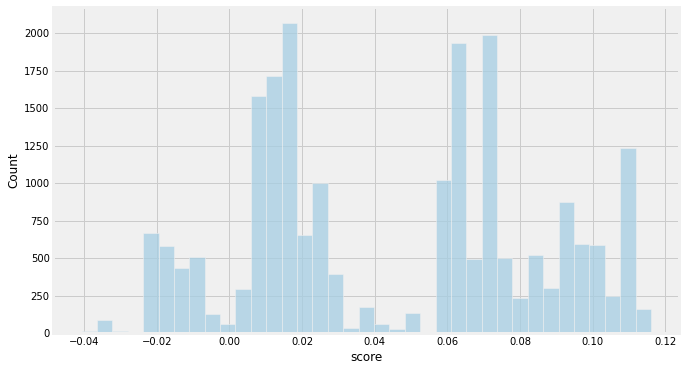

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(test['score'])
plt.show()

In [ ]:
#####################################################

In [ ]:
##
## Это мне непонятно. Надо будет разобраться
##

cmetrics.plot_gain(
    train[['visit', 'treatment', 'visit']],
    treatment_col='treatment',
    outcome_col='visit',
)